In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 0. EDA

In [2]:
data_path = Path("/home/gerard/PycharmProjects/epileptic-detection/data/")  #Path("./data/windows_data/chb01_raw_eeg_128_full.npz")
data = np.load(data_path / "windows_data" / "chb01_raw_eeg_128_full.npz")["arr_0"]
metadata = pd.read_csv(data_path / "metadata" / "chb01_raw_eeg_128_full.csv")

FileNotFoundError: [Errno 2] No such file or directory: '/home/gerard/PycharmProjects/epileptic-detection/data/windows_data/chb01_raw_eeg_128_full.npz'

In [12]:
data.shape, metadata.shape

((21480, 128, 21), (21480, 6))

In [13]:
metadata

,id,label,pacient,index_inicial,periode,recording
0,0,0,1,0,0,0
1,1,0,1,128,0,0
2,2,0,1,256,0,0
3,3,0,1,384,0,0
4,4,0,1,512,0,0
...,...,...,...,...,...,...
21475,21475,0,1,460160,9,5
21476,21476,0,1,460288,9,5
21477,21477,0,1,460416,9,5
21478,21478,0,1,460544,9,5


In [14]:
metadata["label"].value_counts()

0    21413
1       67
Name: label, dtype: int64

### Label 0

In [15]:
sample_metadata = metadata[metadata["label"] == 0].sample()
sample_data = data[sample_metadata.id][0]

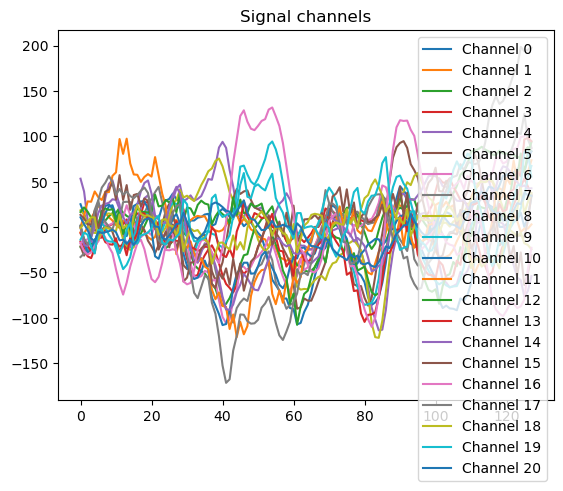

In [17]:
fig, ax = plt.subplots()
for i in range(sample_data.shape[-1]):
    ax.plot(sample_data[:, i], label=f"Channel {i}")

# Enable legend
ax.legend()
ax.set_title("Signal channels")
plt.show()

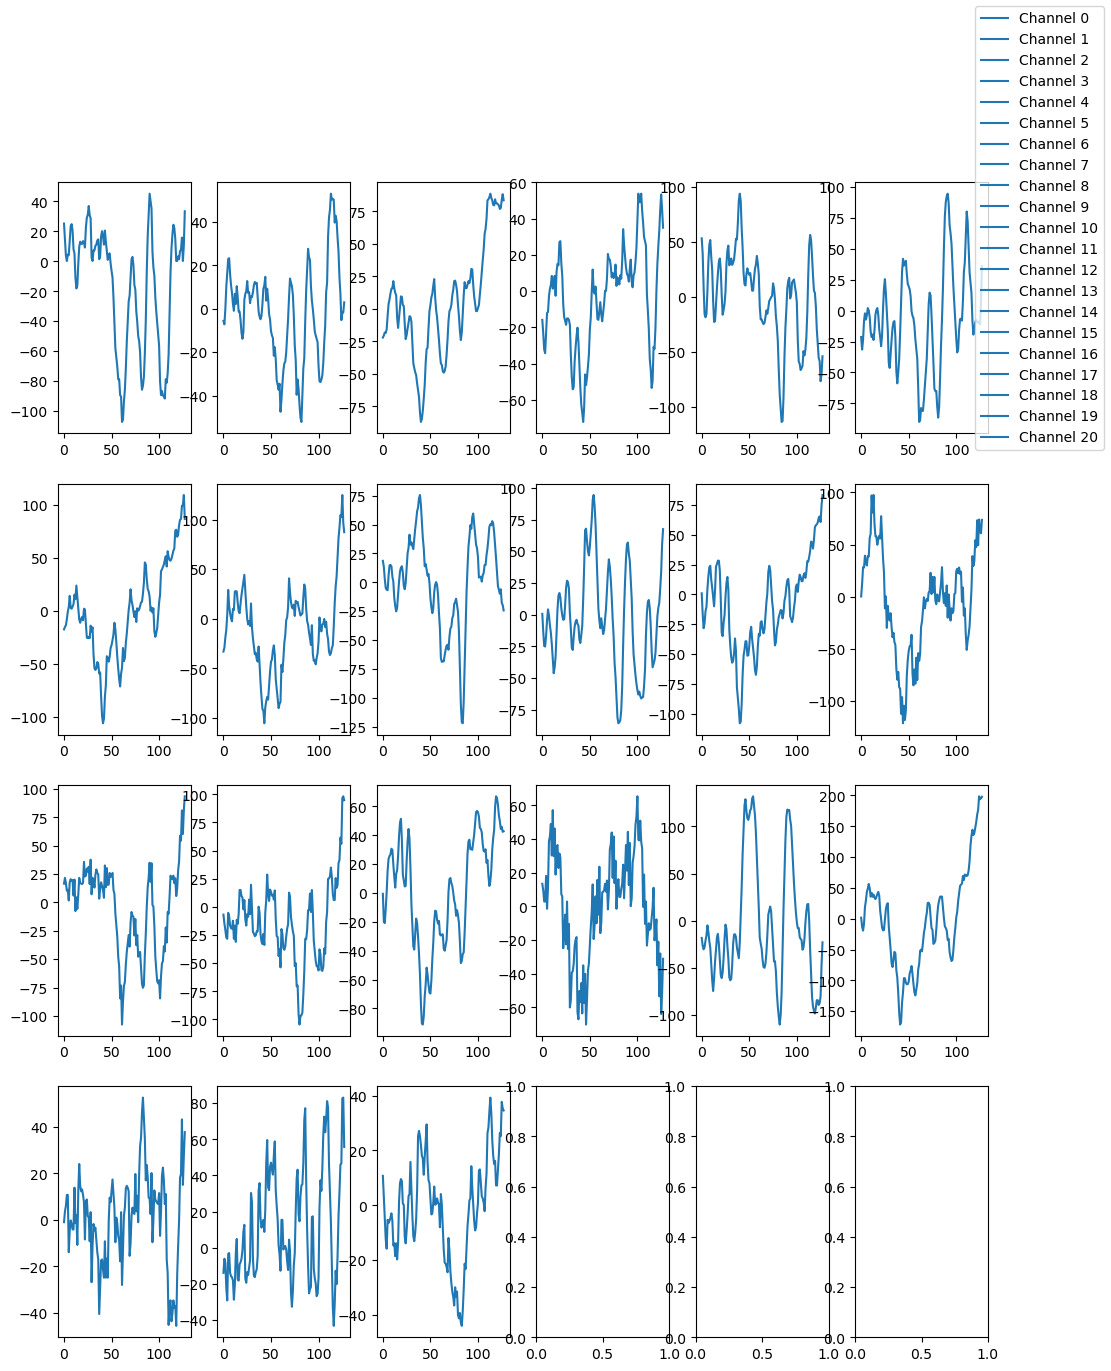

In [18]:
# Subplot: 4, 6
fig, ax = plt.subplots(4, 6, figsize=(12,15))
for i in range(sample_data.shape[-1]):
    ax[i//6, i%6].plot(sample_data[:, i], label=f"Channel {i}")

fig.legend(loc='upper right')
plt.show()

### Label 1

In [19]:
sample_metadata = metadata[metadata["label"] == 1].sample()
sample_data = data[sample_metadata.id][0]

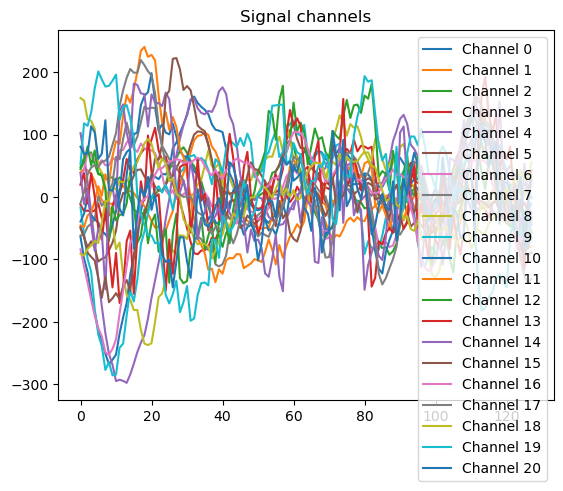

In [20]:
fig, ax = plt.subplots()
for i in range(sample_data.shape[-1]):
    ax.plot(sample_data[:, i], label=f"Channel {i}")

# Enable legend
ax.legend()
ax.set_title("Signal channels")
plt.show()

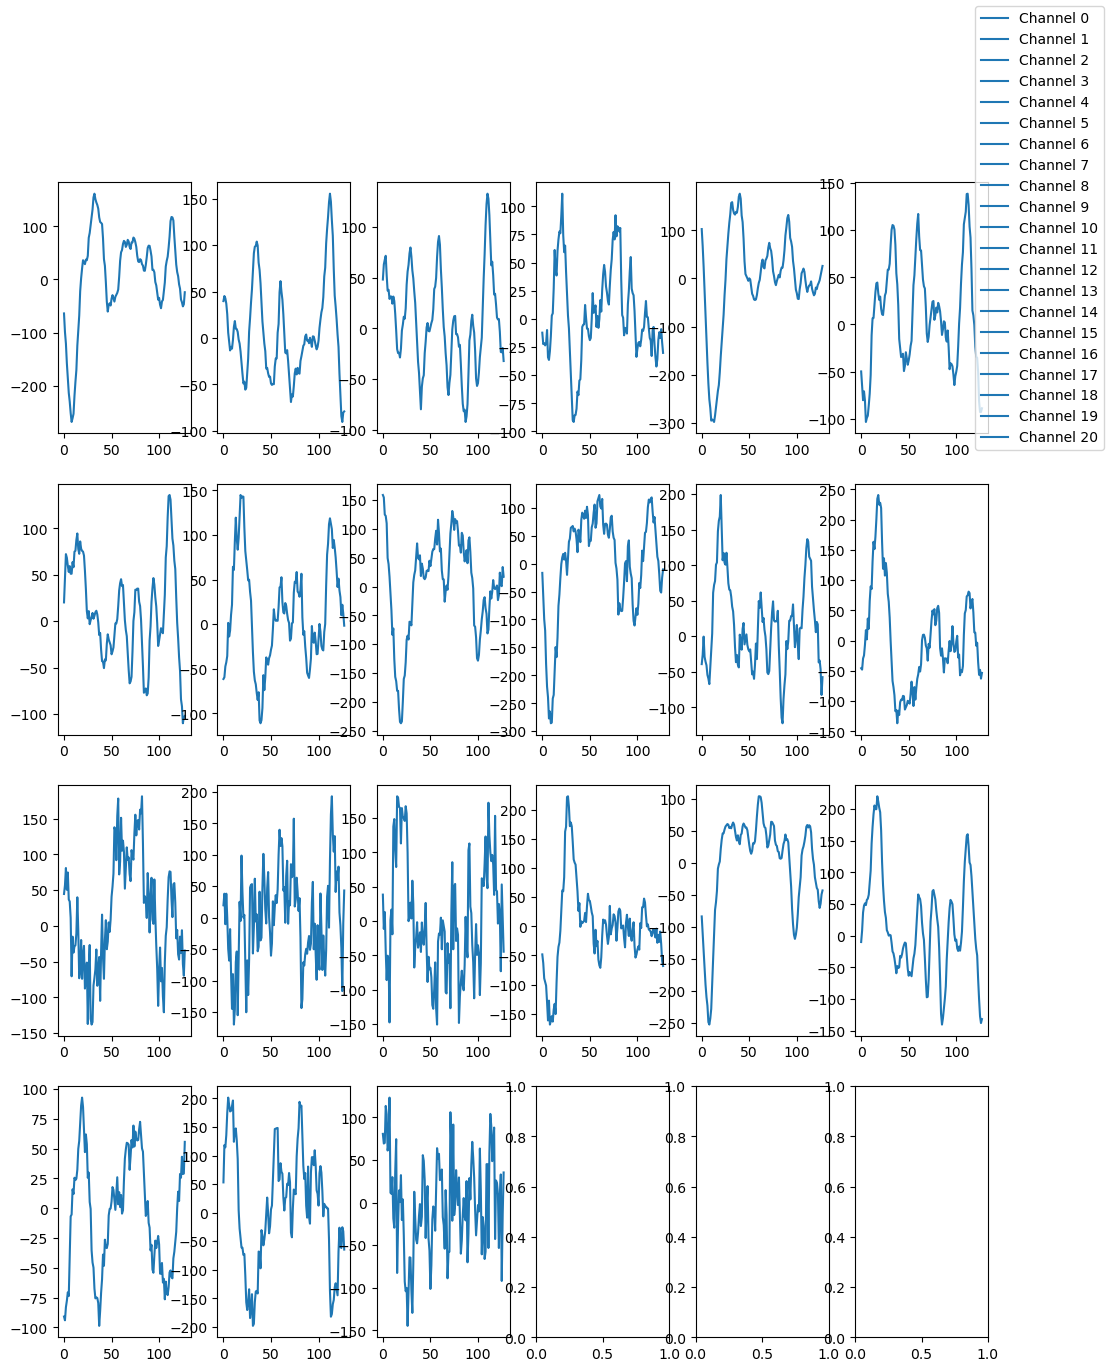

In [21]:
# Subplot: 4, 6
fig, ax = plt.subplots(4, 6, figsize=(12,15))
for i in range(sample_data.shape[-1]):
    ax[i//6, i%6].plot(sample_data[:, i], label=f"Channel {i}")

fig.legend(loc='upper right')
plt.show()

### Visualize entire recording

In [22]:
recording = metadata[metadata["recording"] == 2]

In [23]:
recording["label"].value_counts()

0    3500
1      40
Name: label, dtype: int64

In [24]:
recording.shape, data.shape, data[recording["id"]].shape

((3540, 6), (21480, 128, 21), (3540, 128, 21))

In [25]:
X = data[recording["id"]].reshape(3540*128, 21)
y = np.array(recording["label"].tolist())

In [26]:
X.shape, y.shape

((453120, 21), (3540,))

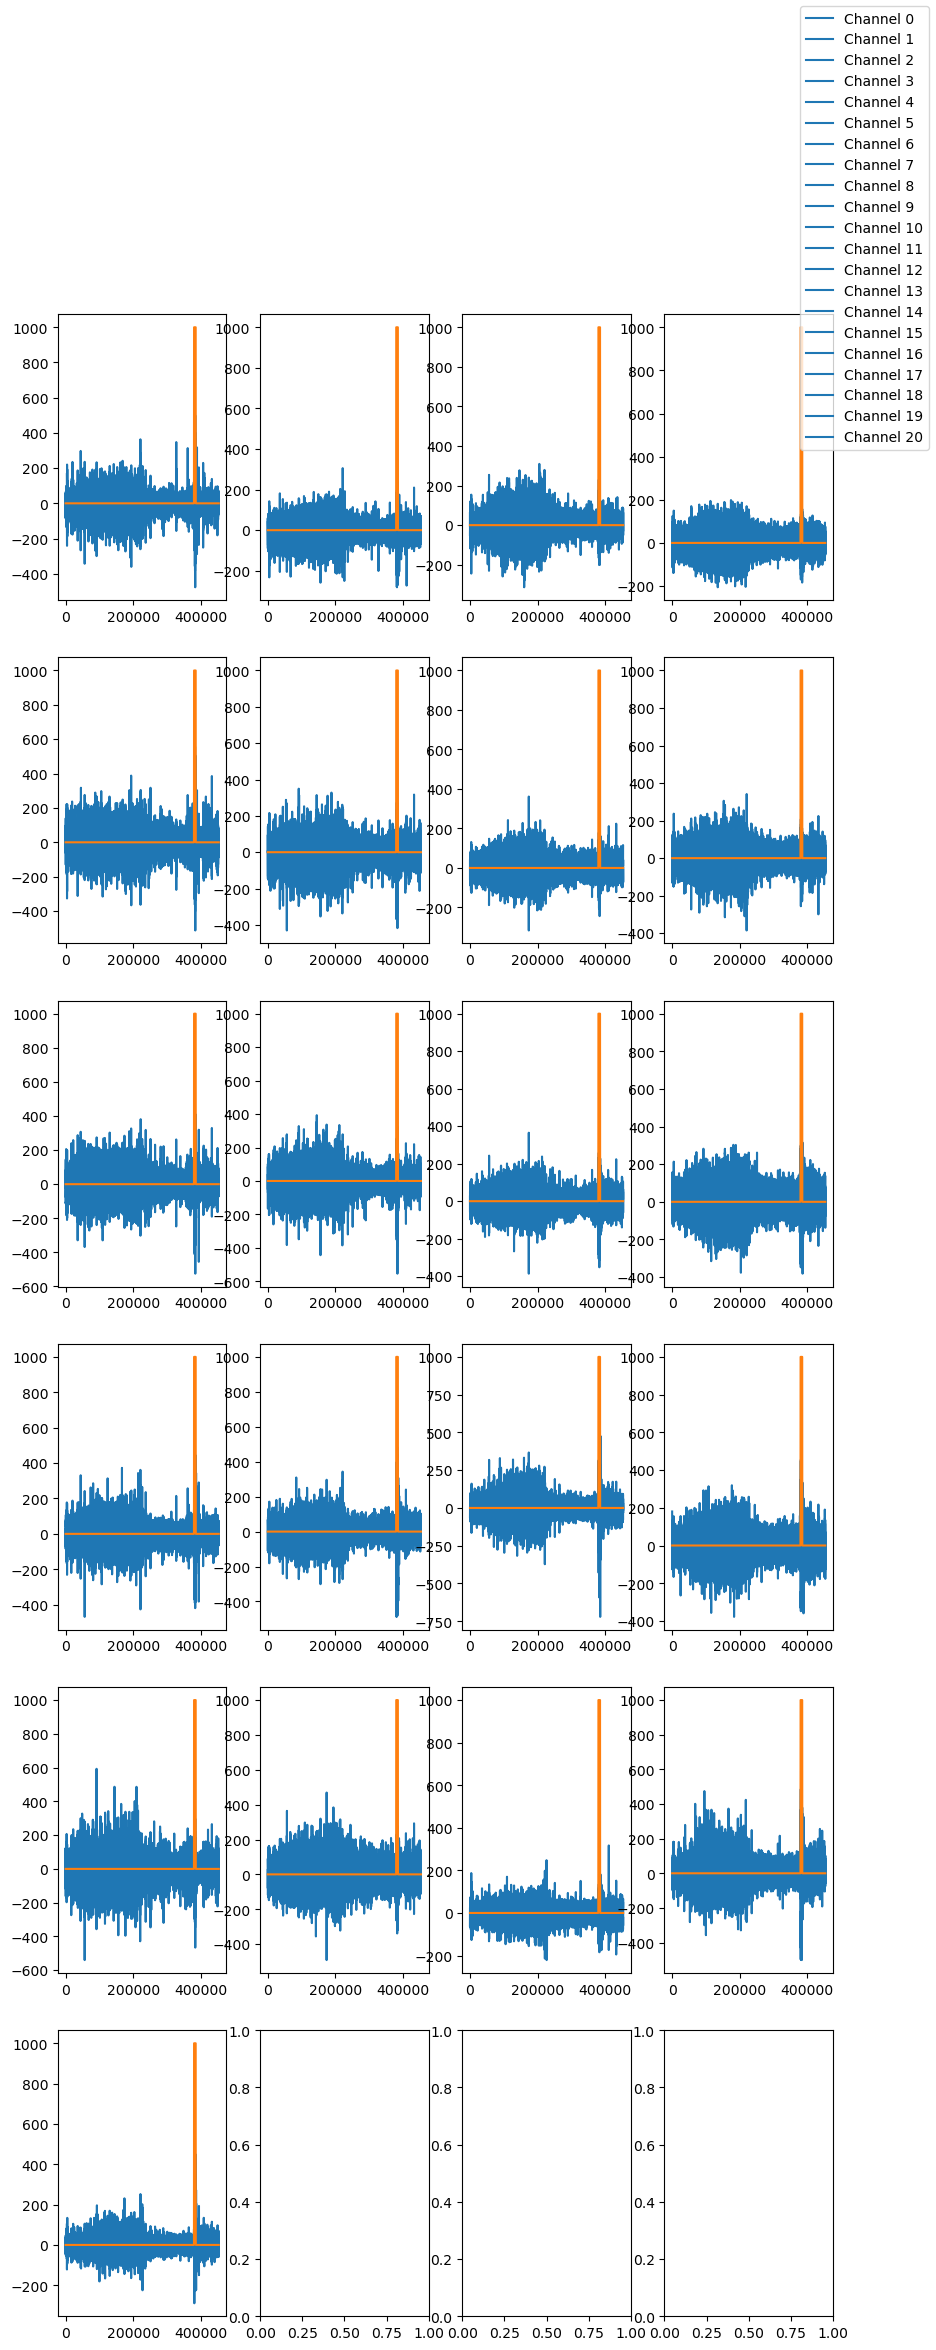

In [29]:
# Subplot: 4, 6
fig, ax = plt.subplots(6, 4, figsize=(10,26))
for i in range(X.shape[-1]):
    ax[i//4, i%4].plot(X[:, i], label=f"Channel {i}")
    ax[i//4, i%4].plot(np.tile(y.reshape(1, y.shape[0]), (128, 1)).flatten('F') * 1000)

fig.legend(loc='upper right')
plt.show()

# 1. Dataset

In [122]:
from pathlib import Path
from typing import Union

import numpy as np
import pandas as pd
import torch
from PIL import Image
from torch.utils.data import Dataset


class EpilepticDataset(Dataset):

    def __init__(self, root_data_dir: Union[str, Path], metadata: pd.DataFrame, transforms=None):
        self.root_data_dir = Path(root_data_dir)
        self.data = self.load_data()
        self.metadata_df = metadata
        self.transforms = transforms

    def load_data(self) -> torch.Tensor:
        return torch.tensor(np.load(self.root_data_dir / "windows_data" / "chb01_raw_eeg_128_full.npz")["arr_0"], dtype=torch.float)

    def __len__(self):
        return len(self.metadata_df)

    def __getitem__(self, idx):
        metadata = self.metadata_df.iloc[idx]
        signal = self.data[idx]

        # Permute (w, c) -> (c, w)
        signal = signal.permute((1, 0))

        target = torch.tensor(metadata["label"], dtype=torch.long)

        metadata = metadata[["id", "pacient", "index_inicial", "periode", "recording"]].to_dict()
        
        sample = {"signal": signal, "target": target, "metadata": metadata}

        if self.transforms:
            sample["signal"] = self.transforms(sample["signal"])

        return sample

In [123]:
root_data_dir = Path("../data/").resolve()
metadata = pd.read_csv(root_data_dir / "metadata" / "chb01_raw_eeg_128_full.csv")

ds = EpilepticDataset(root_data_dir, metadata)

In [124]:
ds[0]

{'signal': tensor([[-1.4593e+02,  1.9536e-01,  1.9536e-01,  ..., -1.8559e+01,
          -1.3089e+01, -6.0562e+00],
         [-1.0452e+02,  1.9536e-01,  1.9536e-01,  ...,  1.7387e+01,
           1.6215e+01,  2.7937e+01],
         [-4.2784e+01,  1.9536e-01,  1.9536e-01,  ...,  2.2857e+01,
           8.0098e+00, -5.8608e-01],
         ...,
         [-5.7241e+01,  1.9536e-01,  5.8608e-01,  ..., -3.4969e+01,
          -3.3016e+01, -1.7387e+01],
         [-2.6471e+02,  5.8608e-01, -2.1490e+00,  ...,  5.1770e+01,
           5.1380e+01,  2.2076e+01],
         [ 9.4750e+01,  1.9536e-01,  1.9536e-01,  ..., -1.9536e-01,
           8.0098e+00, -6.8376e+00]]),
 'target': tensor(0),
 'metadata': {'id': 0,
  'pacient': 1,
  'index_inicial': 0,
  'periode': 0,
  'recording': 0}}

# 2. DataLoader

In [170]:
from pathlib import Path
from typing import Dict

import pandas as pd
import pytorch_lightning as pl
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

#from src.deep_learning.data.dataset import EpilepticDataset


class DataModule(pl.LightningDataModule):
    def __init__(self, root_data_dir: str = './data', batch_size: int = 32, num_workers: int = 4,
                 transforms: Dict = {"train": None, "valid": None, "test": None}):
        super().__init__()
        self.root_data_dir = Path(root_data_dir).resolve()
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.dataset = EpilepticDataset
        self.transforms = transforms

    def setup(self, stage: str = None):
        if stage == 'fit' or stage is None:
            full_train_metadata_df = pd.read_csv(self.root_data_dir / "metadata" / "chb01_raw_eeg_128_full.csv")
            train_metadata_df, valid_metadata_df = train_test_split(full_train_metadata_df, test_size=0.2,
                                                                    random_state=0,
                                                                    stratify=full_train_metadata_df['label'])

            self.train_ds = self.dataset(self.root_data_dir, train_metadata_df, transforms=self.transforms["train"])
            self.valid_ds = self.dataset(self.root_data_dir, valid_metadata_df, transforms=self.transforms["valid"])

        if stage == 'test' or stage is None:
            # TODO test csv
            test_metadata_df = pd.read_csv(self.root_data_dir / "metadata" / "chb01_raw_eeg_128_full.csv")
            self.test_ds = self.dataset(self.root_data_dir, test_metadata_df, transforms=self.transforms["test"])

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.valid_ds, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.batch_size, num_workers=self.num_workers)


In [171]:
root_data_dir = Path("../data/").resolve()
dm = DataModule(root_data_dir, batch_size=4)
dm.setup()

In [172]:
next(iter(dm.train_dataloader()))

{'signal': tensor([[[ -29.1087,  -31.8437,  -39.2674,  ...,   17.7778,    0.1954,
             -7.2283],
          [  29.4994,   25.5922,   36.1416,  ...,  -17.3871,  -28.7179,
              9.1819],
          [   8.0098,   24.0293,   21.2943,  ...,    6.0562,   51.3797,
              3.7118],
          ...,
          [ -46.6911,  -22.8571,  -36.9231,  ...,   -9.1819,   11.9170,
             -9.1819],
          [   3.3211,  -12.6984,  -20.5128,  ...,  -27.1551,  -16.9963,
            -45.9096],
          [  -6.4469,   -5.2747,   -5.6654,  ...,   -4.1026,   10.7448,
             -8.0098]],
 
         [[  -5.2747,  -22.0757,  -34.1880,  ..., -123.2723, -121.7094,
           -117.8022],
          [ -13.0891,  -19.7314,  -20.1221,  ...,   -9.1819,   -7.2283,
            -19.3407],
          [   2.9304,   13.8706,    7.2283,  ...,    0.1954,   -2.1490,
            -19.3407],
          ...,
          [  17.3871,   11.9170,   11.9170,  ...,  -54.8962,  -39.6581,
              5.6654],
       

# 3. Model (tsai)

In [173]:
from tsai.models.FCNPlus import FCNPlus

In [174]:
# Input: 21, Output: 2
FCNPlus(21, 2)

FCNPlus(
  (backbone): _FCNBlockPlus(
    (convblock1): ConvBlock(
      (0): Conv1d(21, 128, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (convblock2): ConvBlock(
      (0): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (convblock3): ConvBlock(
      (0): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (add): Sequential()
  )
  (head): Sequential(
    (0): AdaptiveAvgPool1d(output_size=1)
    (1): Squeeze(dim=-1)
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [175]:
tsai_model = FCNPlus(21, 2)

# 4. LightningModule

In [176]:
import pytorch_lightning as pl
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics


class LightningModule(pl.LightningModule):
    """Expects a tsai model as an input with a backbone and a head."""

    def __init__(self, model, num_classes=2, learning_rate=1e-2):
        super().__init__()

        # log hyperparameters
        self.save_hyperparameters()
        self.learning_rate = learning_rate

        self.num_classes = num_classes
        self.model = model

        self.softmax = nn.Softmax()
        self.loss = nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.Accuracy(num_classes=num_classes)
        self.f_score = torchmetrics.F1Score(task='binary')

    def forward(self, x, metadata):
        x = self.model.backbone(x)
        x = self.model.head(x)
        x = self.softmax(x)
        return x

    def training_step(self, batch, batch_idx):
        images, target, metadata = batch["signal"], batch["target"], batch["metadata"]
        logits = self.forward(images, metadata)
        loss = self.loss(logits, target)

        # training metrics
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, target.int())
        f_score = self.f_score(preds, target.int())
        self.log('train_loss', loss, on_step=True, logger=True)
        self.log('train_acc', acc, on_epoch=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, target, metadata = batch["signal"], batch["target"], batch["metadata"]
        logits = self.forward(images, metadata)
        loss = self.loss(logits, target)

        # validation metrics
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, target.int())
        f_score = self.f_score(preds, target.int())
        self.log('val_loss', loss, on_step=True, logger=True)
        self.log('val_acc', acc, on_epoch=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        images, target, metadata = batch["signal"], batch["target"], batch["metadata"]
        logits = self.forward(images, metadata)
        loss = self.loss(logits, target)

        # test metrics
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, target)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1, verbose=True)
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

In [177]:
num_classes = 2
model = LightningModule(tsai_model, num_classes=num_classes, learning_rate=1e-3)

/home/gerard/miniconda3/envs/epileptic-detection/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:268: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(


# 5. Logger - Wandb

In [178]:
from pytorch_lightning.loggers import WandbLogger

In [179]:
wandb_logger = None  # WandbLogger(project='epileptic-detection', job_type='train')

# 6. Callbacks

In [180]:
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

In [181]:
callbacks = [
    #EarlyStopping(monitor="val_loss", min_delta=0.00, patience=3, verbose=False, mode="max"),
    LearningRateMonitor(),
    ModelCheckpoint(dirpath="./checkpoints", monitor="val_loss", filename="model_{epoch:02d}_{val_loss:.2f}")
]

# 7. Transforms

In [182]:
from torchvision import transforms
from torch.nn.functional import normalize

In [183]:
class ZScoreNormalize(object):
    def __call__(self, tensor):
        # Calculate the mean and standard deviation of the tensor
        mean = torch.mean(tensor)
        std = torch.std(tensor)

        # Normalize the tensor by subtracting the mean and dividing by the standard deviation
        normalized_tensor = (tensor - mean) / std

        return normalized_tensor

In [184]:
class L2Normalize(object):
    def __call__(self, tensor):
        # Normalize the tensor using L2 normalization
        normalized_tensor = normalize(tensor, p=2, dim=None)

        return normalized_tensor

# 8. Trainer

In [185]:
import pytorch_lightning as pl

In [186]:
trainer = pl.Trainer(max_epochs=30,
                     gpus=0,
                     logger=wandb_logger,
                     callbacks=callbacks,
                     enable_progress_bar=True)

/home/gerard/miniconda3/envs/epileptic-detection/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


# 9. lr_find

In [187]:
def lr_find(trainer: pl.Trainer, model, dm: pl.LightningDataModule):
    # Run learning rate finder
    lr_finder = trainer.tuner.lr_find(model, dm)

    # Results can be found in
    print(lr_finder.results)

    # Plot with
    fig = lr_finder.plot(suggest=True)
    fig.show()
    fig.savefig("./lr_find.png")

    # Pick point based on plot, or get suggestion
    new_lr = lr_finder.suggestion()
    print(f"Using suggested lr: {new_lr}")

In [188]:
lr_find(trainer, model, dm)

Adjusting learning rate of group 0 to 1.0000e-03.


/tmp/ipykernel_11634/684455625.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)
Finding best initial lr: 100%|██████████| 100/100 [00:04<00:00, 20.89it/s]
Restoring states from the checkpoint path at /home/gerard/PycharmProjects/epileptic-detection/nbs/.lr_find_9444a68e-0b00-42b3-ac79-6490e690b192.ckpt
/tmp/ipykernel_11634/2010533465.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


{'lr': [1e-08, 1.4454397707459274e-08, 1.7378008287493753e-08, 2.0892961308540398e-08, 2.51188643150958e-08, 3.019951720402016e-08, 3.630780547701014e-08, 4.36515832240166e-08, 5.248074602497726e-08, 6.309573444801934e-08, 7.585775750291837e-08, 9.120108393559096e-08, 1.0964781961431852e-07, 1.3182567385564074e-07, 1.5848931924611133e-07, 1.9054607179632475e-07, 2.2908676527677735e-07, 2.7542287033381663e-07, 3.311311214825911e-07, 3.9810717055349735e-07, 4.786300923226383e-07, 5.75439937337157e-07, 6.918309709189366e-07, 8.317637711026709e-07, 1e-06, 1.2022644346174132e-06, 1.445439770745928e-06, 1.7378008287493761e-06, 2.089296130854039e-06, 2.5118864315095797e-06, 3.0199517204020163e-06, 3.630780547701014e-06, 4.365158322401661e-06, 5.248074602497728e-06, 6.3095734448019305e-06, 7.585775750291836e-06, 9.120108393559096e-06, 1.0964781961431852e-05, 1.3182567385564076e-05, 1.584893192461114e-05, 1.9054607179632464e-05, 2.2908676527677725e-05, 2.7542287033381663e-05, 3.311311214825911e

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5024099000>
Traceback (most recent call last):
  File "/home/gerard/miniconda3/envs/epileptic-detection/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/gerard/miniconda3/envs/epileptic-detection/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1430, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/gerard/miniconda3/envs/epileptic-detection/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/home/gerard/miniconda3/envs/epileptic-detection/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/home/gerard/miniconda3/envs/epileptic-detection/lib/python3.10/multiprocessing/connection.py", line 936, in wait
    ready = selector.select(timeout)
  File "/home/gerard/min

# 10. Train

In [ ]:
trainer.fit(model, dm)

# 11. Optuna